# **Analisis del Precio de los tickets para el Tren de Alta Velocidad Español**
Por Guillermo Gil Ochoa

# Importando librerias

In [1]:
import numpy as np 
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
import math
import datetime

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from plotly.offline import init_notebook_mode, iplot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression,LogisticRegression
from plotly.offline import init_notebook_mode, iplot

# Preparando el Dataset

In [2]:
data = pd.read_csv("../input/spanish-high-speed-rail-system-ticket-pricing/thegurus-opendata-renfe-trips.csv",nrows=3579770)

Eliminando columnas irrelevantes

In [3]:
data = data.drop(columns=['id','seats','meta','company'])
cols = list(data.columns)
cols = [cols[-1]] + cols[:-1]
data = data[cols]

data.to_csv("./renfe.csv",index=False)

# Cargando el Dataset

In [4]:
data = pd.read_csv('./renfe.csv')
data.head()

,insert_date,origin,destination,departure,arrival,duration,vehicle_type,vehicle_class,price,fare
0,2019-04-11 21:49:46,MADRID,BARCELONA,2019-04-18 05:50:00,2019-04-18 08:55:00,3.08,AVE,Preferente,68.95,Promo
1,2019-04-11 21:49:46,MADRID,BARCELONA,2019-04-18 13:25:00,2019-04-18 16:24:00,2.98,AVE-TGV,Turista,107.70,Flexible
2,2019-04-11 21:49:46,MADRID,BARCELONA,2019-04-18 06:30:00,2019-04-18 09:20:00,2.83,AVE,Turista,75.40,Promo
3,2019-04-11 21:49:46,MADRID,BARCELONA,2019-04-18 15:30:00,2019-04-18 18:40:00,3.17,AVE,Preferente,NaN,Promo
4,2019-04-11 21:49:46,MADRID,BARCELONA,2019-04-18 07:00:00,2019-04-18 09:30:00,2.50,AVE,Turista Plus,106.75,Promo


Informacion de los campos que contienen la tabla

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3579770 entries, 0 to 3579769
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   insert_date    object 
 1   origin         object 
 2   destination    object 
 3   departure      object 
 4   arrival        object 
 5   duration       float64
 6   vehicle_type   object 
 7   vehicle_class  object 
 8   price          float64
 9   fare           object 
dtypes: float64(2), object(8)
memory usage: 273.1+ MB


# Preparando los datos
Comprobando los valores nulos en el Dataset

In [6]:
data.isnull().sum()

insert_date           0
origin                0
destination           0
departure             0
arrival               0
duration              0
vehicle_type          0
vehicle_class     13722
price            497426
fare              13722
dtype: int64

Completando los precios con valor nulo con el precio medio

In [7]:
data['price'].fillna(data['price'].mean(),inplace=True)

/tmp/ipykernel_33/2889074071.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Desechamos los registros con nulos

In [8]:
data.dropna(inplace=True)

Eliminando los valores irrelevantes

In [9]:
data.drop('insert_date',axis=1,inplace=True)

In [10]:
data.isnull().sum()

origin           0
destination      0
departure        0
arrival          0
duration         0
vehicle_type     0
vehicle_class    0
price            0
fare             0
dtype: int64

# Numero de rutas que existen en el Dataset

In [11]:
data['route'] = data['origin']+' a '+data['destination']
print('Hay un total de {} rutas en el dataframe'.format(data['route'].nunique()))

Hay un total de 8 rutas en el dataframe


# **EXPLORACION DEL DATO**
# Numero de personas con el mismo origen

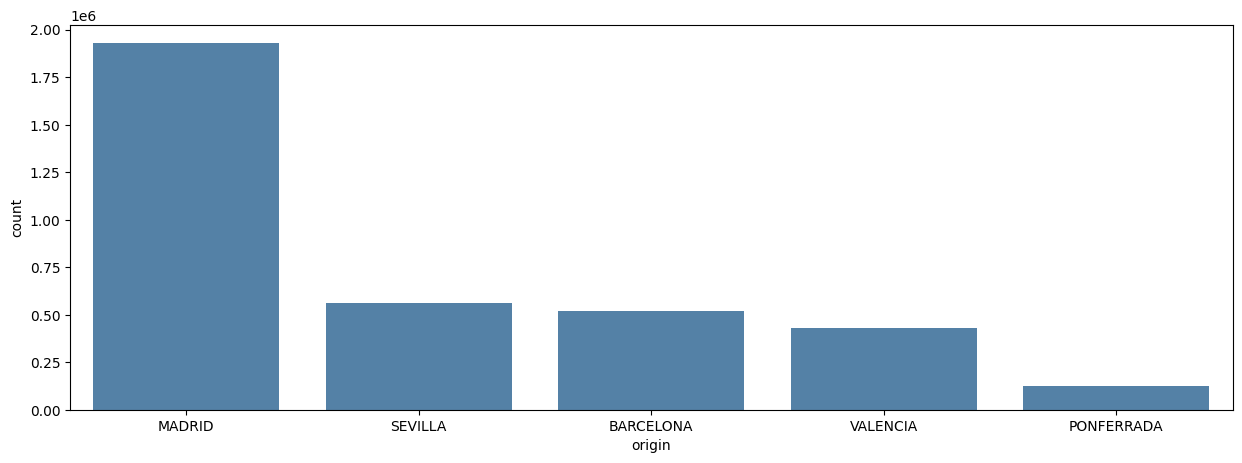

In [12]:
fig,ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(data, x='origin', color='steelblue')
plt.show()

**Análisis de la Gráfica:**
1. MADRID: Tiene el mayor recuento, con aproximadamente 2,000,000.
2. SEVILLA: Tiene un recuento significativamente menor, alrededor de 500,000.
3. BARCELONA: Similar a Sevilla, también alrededor de 500,000.
4. VALENCIA: Tiene un recuento menor que Sevilla y Barcelona, alrededor de 250,000.
5. PONFERRADA: Tiene el recuento más bajo, alrededor de 100,000.

**Interpretación:**
* Desbalance de Recuento: Madrid tiene un recuento significativamente mayor en comparación con las otras ciudades, lo que podría indicar que Madrid es un punto central o más importante para el transporte de trenes.
* Segunda y Tercera Posición: Sevilla y Barcelona tienen recuentos muy similares, lo que podría indicar que estas ciudades tienen una importancia similar.
* Valencia y Ponferrada: Estas ciudades tienen recuentos menores, con Ponferrada siendo la ciudad con el recuento más bajo.

# Numero de personas con el mismo destino

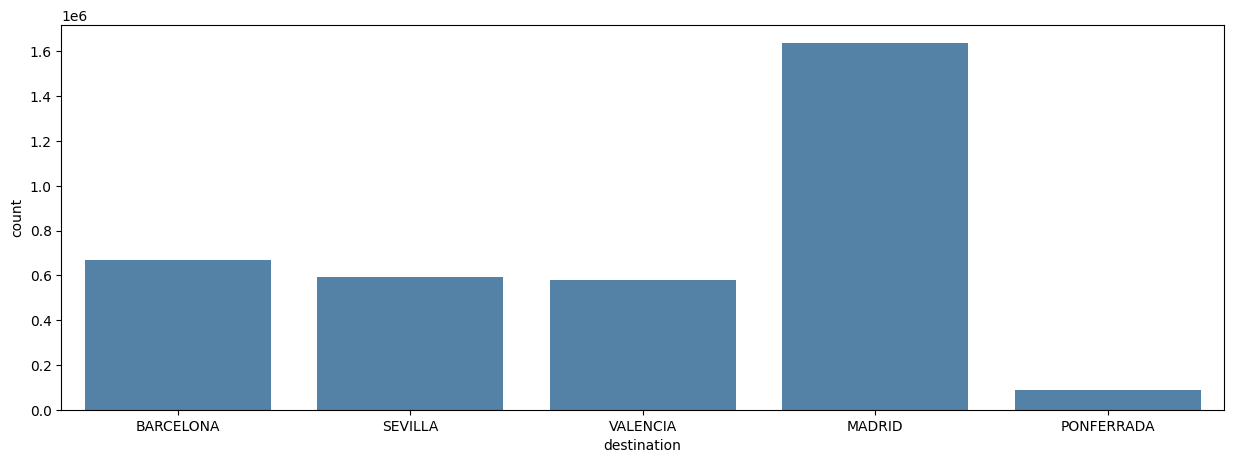

In [13]:
fig,ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(data, x='destination', color='steelblue')
plt.show()

##### La segunda gráfica es similar a la primera, pero muestra los datos clasificados por destino en lugar de origen.

**Análisis de la Segunda Gráfica:**
1. MADRID: Al igual que en la primera gráfica, Madrid tiene el mayor recuento como destino, con aproximadamente 1,700,000.
2. BARCELONA: Tiene un recuento significativo, alrededor de 700,000.
3. SEVILLA: Similar a Barcelona, con un recuento ligeramente menor, alrededor de 600,000.
4. VALENCIA: Tiene un recuento similar al de Sevilla, alrededor de 600,000.
5. PONFERRADA: Tiene el recuento más bajo como destino, alrededor de 100,000.

**Comparación Entre las Dos Gráficas:**
* Madrid: Es tanto el principal origen como destino en ambas gráficas, pero el recuento como destino es ligeramente menor que como origen.
* Barcelona y Sevilla: Tienen recuentos similares como destinos y están en una posición intermedia tanto como origen como destino.
* Valencia: Tiene una cantidad menor de recuentos tanto como origen como destino, aunque no es la ciudad con menos recuentos.
* Ponferrada: Tiene el recuento más bajo tanto como origen como destino, indicando quizás una menor participación en el evento o actividad medida.

# Numero de personas con el mismo tipo de tren

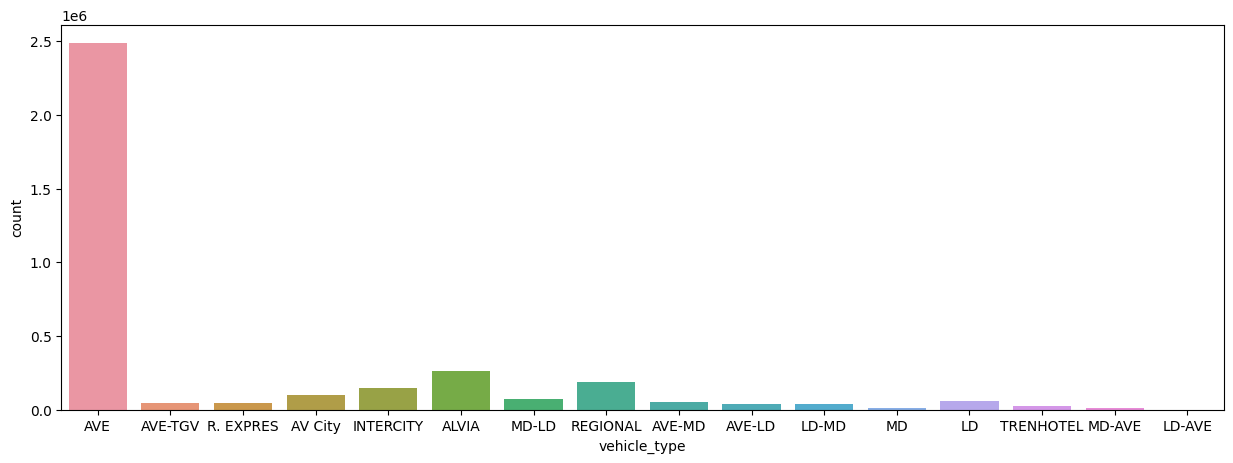

In [14]:
fig,ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(data, x='vehicle_type')
plt.show()

**Análisis de la Tercera Gráfica:**
1. AVE: Tiene el recuento más alto, con aproximadamente 2,500,000.
2. ALVIA: Tiene un recuento significativo, alrededor de 200,000.
3. REGIONAL: Similar a ALVIA, con un recuento alrededor de 150,000.
4. INTERCITY y AV City: Tienen recuentos menores pero significativos, alrededor de 100,000 cada uno.
5. Otros Tipos de Vehículos: Tienen recuentos significativamente menores, todos por debajo de 100,000.
**Interpretación:**
* Dominio del AVE: El AVE tiene un recuento significativamente mayor que cualquier otro tipo de vehículo, lo que indica que es el medio de transporte predominante.
* Popularidad de ALVIA y REGIONAL: Aunque están lejos del recuento del AVE, estos dos tipos de vehículos también son relativamente populares.
* Diversidad de Tipos de Vehículos: Hay una gran variedad de tipos de vehículos, pero muchos tienen recuentos muy bajos en comparación con el AVE.

# Numero de personas con cada tipo de clase

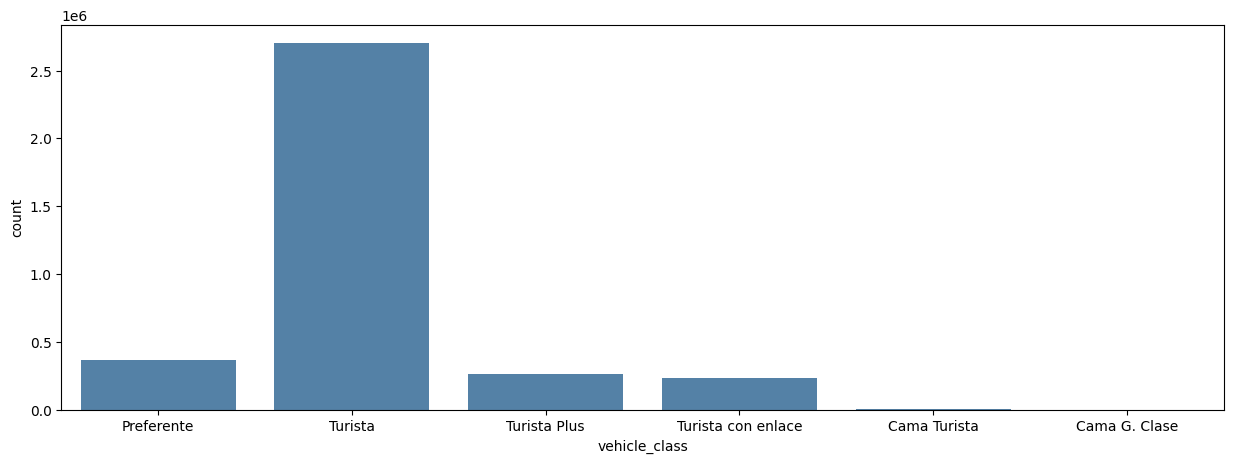

In [15]:
fig,ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(data, x='vehicle_class', color='steelblue')
plt.show()

**Análisis de la Gráfica:**
1. Preferente:
Valor: 0.45 millones
Observación: La clase de billete "Preferente" tiene un recuento de billetes justo por debajo de 0.5 millones, lo que indica una demanda moderada.

2. Turista:
Valor: 2.6 millones
Observación: La clase de billete "Turista" es la más popular, con un recuento por encima de 2.5 millones. Esto sugiere que esta clase es la más accesible o preferida por la mayoría de los viajeros.

3. Turista Plus y Turista con Enlace:
Valor: 0.4 millones cada una
Observación: Ambas clases tienen recuentos similares, ambos por debajo de "Preferente". Esto podría indicar que tienen una popularidad similar, pero menor en comparación con "Preferente".

4. Cama Turista y Cama G Clase:
Valor: 0.01 millones cada una
Observación: Estas clases tienen recuentos muy bajos, casi a 0, lo que indica una demanda muy baja. Esto puede deberse a que son opciones menos populares o más caras, o simplemente porque se usan menos en comparación con las otras clases.

**Interpretación:**
* Turista es claramente la clase de billete más popular, lo que puede indicar que es la más económica o la más adecuada para la mayoría de los viajeros.
* Preferente tiene una demanda significativa, pero no tanto como Turista.
* Las clases Turista Plus y Turista con Enlace tienen una demanda similar, pero menor que Preferente.
* Las clases Cama Turista y Cama G Clase tienen una demanda muy baja, lo que puede indicar que no son opciones populares entre los viajeros.

# Numero de billeres por precio

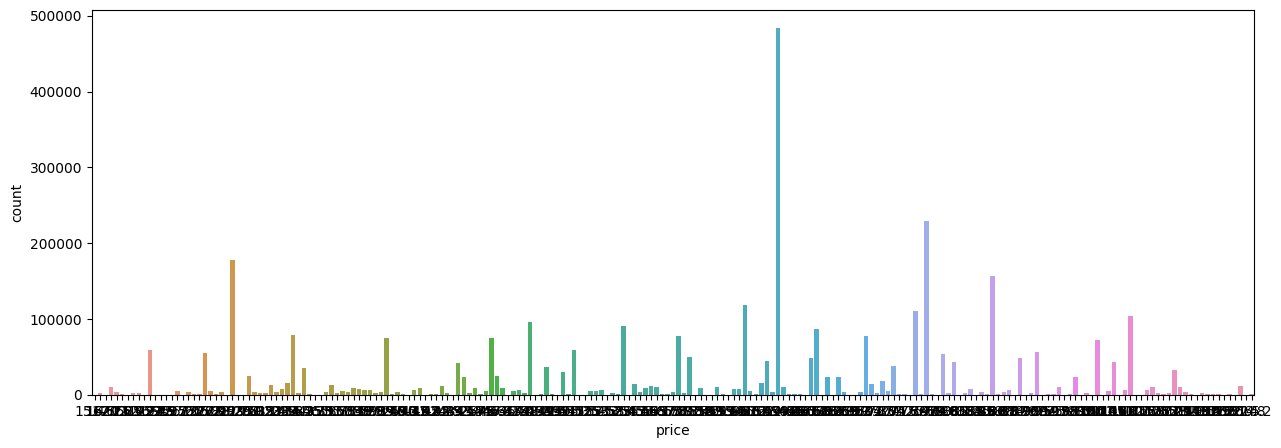

In [16]:
fig,ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(data, x='price')
plt.show()

# Densidad del precio

/tmp/ipykernel_33/353446938.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



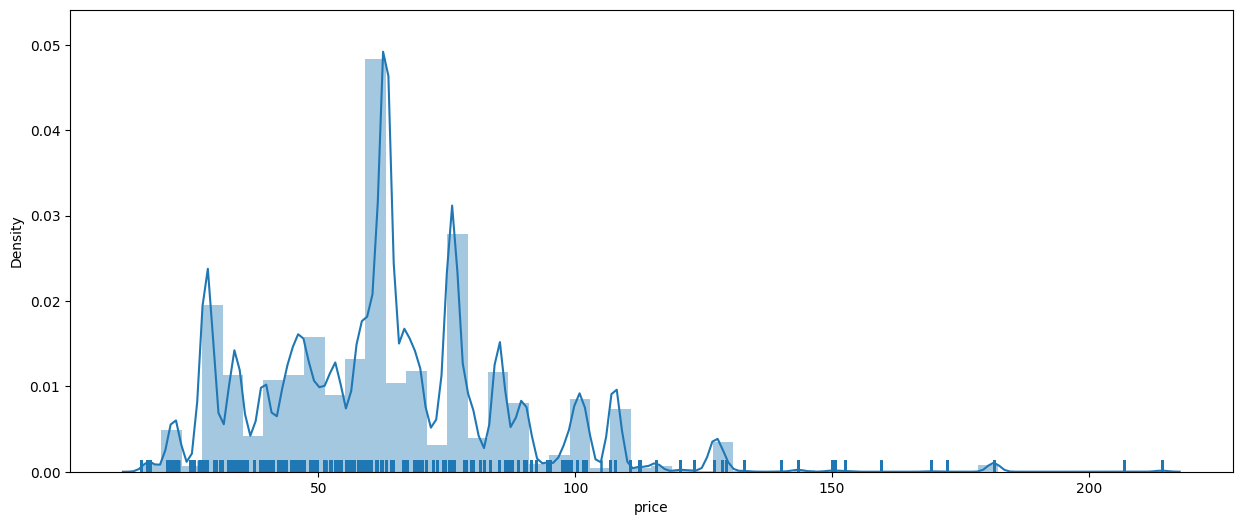

In [17]:
f,ax = plt.subplots(figsize=(15,6))
ax = sns.distplot(data['price'],rug=True)
plt.show()

**Observaciones:**
1. Distribución Bimodal:
La gráfica muestra una distribución bimodal, lo que significa que hay dos picos distintos en la densidad de los precios. El primer pico ocurre alrededor del precio de 50 y el segundo, menos pronunciado, ocurre alrededor del precio de 100.
2. Concentración de Precios:
La mayor densidad de precios se encuentra entre 30 y 80. Esto sugiere que la mayoría de los precios están en este rango.
Fuera de este rango, la densidad de los precios disminuye significativamente.
3. Valores Atípicos:
Hay algunos precios más allá de 150 que tienen muy baja densidad, lo que indica que son valores atípicos o menos comunes.
4. Fluctuaciones:
La línea de densidad muestra fluctuaciones menores entre los picos, lo que puede indicar la presencia de varios subgrupos dentro de los datos de precios.
**Interpretación:**
* Patrones de Precios:
La distribución bimodal sugiere que los datos de precios pueden estar compuestos por dos grupos principales. Estos grupos podrían representar diferentes segmentos de mercado, categorías de productos o algún otro factor diferenciador.
* Rango Principal:
La mayoría de los precios se encuentran entre 30 y 80, indicando que este es el rango de precios más común o accesible.
* Precios Altos y Bajos:
Los precios más allá de 150 son relativamente raros, lo que podría indicar productos premium o segmentos de mercado de nicho.
* Necesidad de Agrupamiento:
Podría ser útil agrupar los precios en rangos más amplios para simplificar la interpretación y análisis, especialmente si se desea hacer una segmentación de mercado.

# Comparativa de la clase de viaje contra el precio

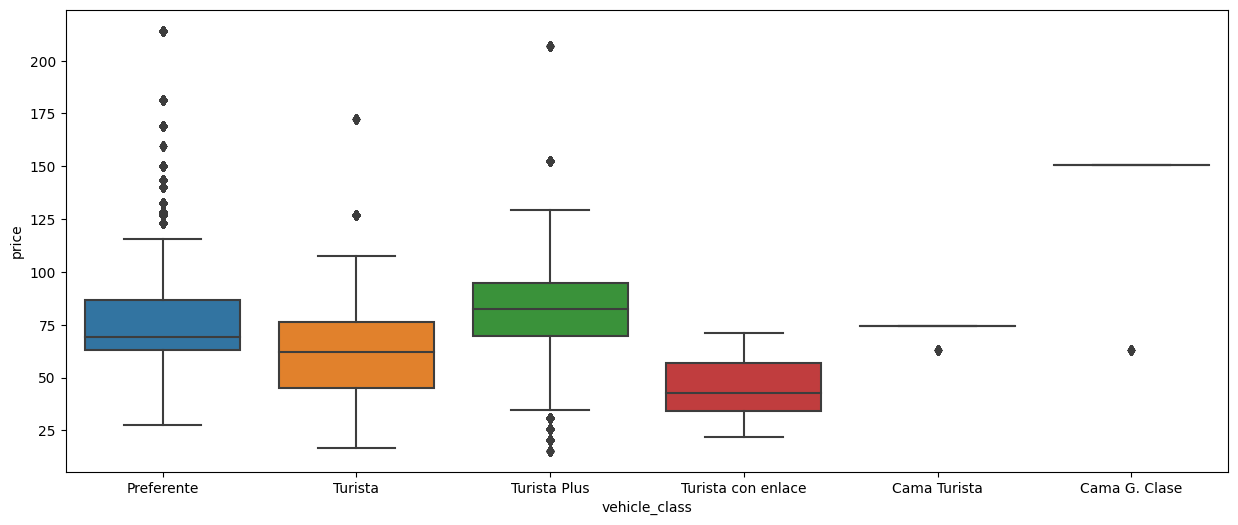

In [18]:
f,ax = plt.subplots(figsize=(15,6))
ax = sns.boxplot(x='vehicle_class',y='price',data=data)
plt.show()

**Observaciones:**
1. Preferente:
El rango intercuartílico es amplio, con una mediana alrededor de 75.
Hay varios valores atípicos por encima de 125, con el más alto superando los 200.
2. Turista:
Tiene una mediana alrededor de 60, con un rango intercuartílico más estrecho que Preferente.
Algunos valores atípicos están por encima de 100.
3. Turista Plus:
La mediana es similar a Preferente, alrededor de 75-80.
Menos valores atípicos comparado con Preferente, pero algunos notables por encima de 125.
4. Turista con enlace:
La mediana está cerca de 50, con un rango intercuartílico relativamente estrecho.
Menos valores atípicos, con algunos por encima de 75.
5. Cama Turista y Cama G. Clase:
Menos datos comparativos y una dispersión de valores menos aparente.
Para Cama G. Clase, parece haber un único precio sin variabilidad visible.
**Interpretación:**
* Distribución y Variabilidad:
Las clases Preferente y Turista Plus tienen una mayor variabilidad en los precios, indicando una gama más amplia de precios disponibles.
La clase Turista y Turista con enlace tienen precios más concentrados y menos dispersión, lo que puede indicar una estructura de precios más homogénea.
* Valores Atípicos:
Las clases Preferente y Turista tienen varios valores atípicos altos. Esto puede sugerir ocasiones en que se ofrecen precios significativamente más altos, posiblemente debido a factores como demanda alta, servicios adicionales o fechas especiales.
* Comparación de Clases:
Las clases de mayor comodidad como Preferente y Turista Plus tienden a tener precios medianos más altos, lo cual es esperable.
La menor variabilidad y precios más bajos en Turista con enlace indican que es una opción más económica y homogénea.

# Comparativa de tipo de tren contra el precio

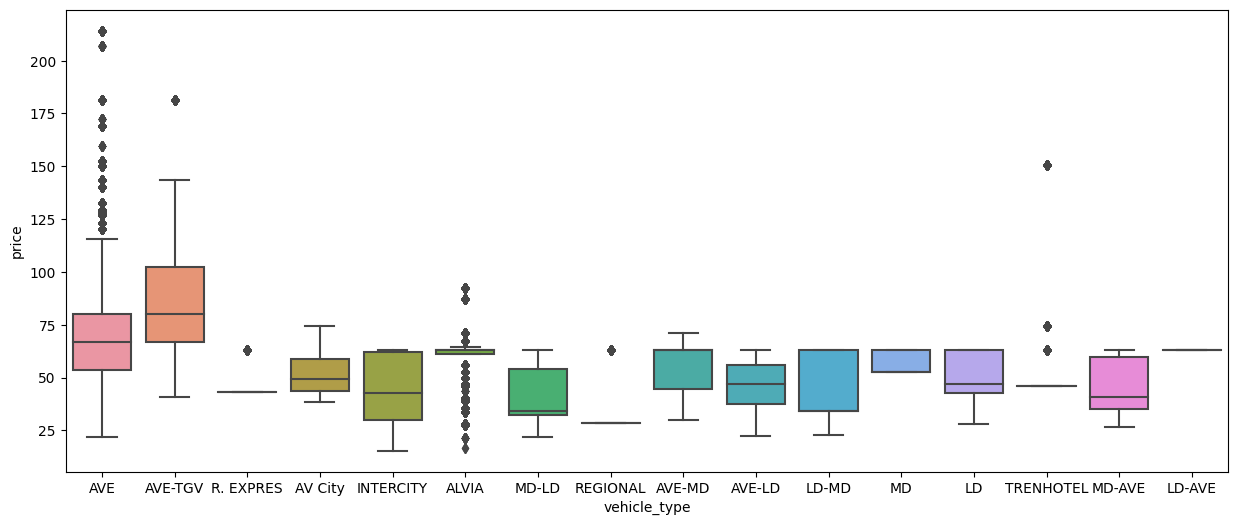

In [19]:
f,ax = plt.subplots(figsize=(15,6))
ax = sns.boxplot(x='vehicle_type',y='price',data=data)
plt.show()

# **Análisis General**

1. Mediana:
La línea horizontal dentro de cada caja representa la mediana del precio para cada tipo de vehículo.
Observamos que los trenes "AVE" y "AVE-TGV" tienen medianas más altas en comparación con otros tipos de vehículos.
2. IQR - Rango Intercuartílico:
La longitud de la caja representa el IQR, es decir, el rango donde se encuentra el 50% central de los datos.
"AVE", "AVE-TGV" y "INTERCITY" tienen cajas más amplias, indicando una mayor variabilidad en los precios.
3. Whiskers:
Los bigotes se extienden desde los cuartiles hasta los valores máximos y mínimos dentro de 1.5 veces el IQR.
Los bigotes de "AVE", "AVE-TGV" y "INTERCITY" son más largos, mostrando mayor dispersión en los datos.
4. Outliers:
Los puntos individuales fuera de los bigotes son valores atípicos.
"AVE", "ALVIA", y "LD" presentan varios valores atípicos, especialmente "AVE" con valores muy elevados.
5. Comparación entre Tipos de Vehículos:
"AVE" y "AVE-TGV" tienen los precios más altos y mayor dispersión en comparación con otros tipos de trenes.
"REGIONAL" y "MD-LD" presentan precios más bajos y menos dispersión.
"TRENHOTEL" tiene muy pocos datos pero muestra precios altos con algunos valores atípicos.
**Conclusiones**
* Tipos de Tren con Precios Elevados: Los trenes "AVE" y "AVE-TGV" son los que tienen los precios más altos, reflejando posiblemente su velocidad y calidad superior.
* Variabilidad: Hay una gran variabilidad en los precios de los trenes "AVE", "AVE-TGV" y "INTERCITY", mientras que trenes como "REGIONAL" y "MD-LD" tienen menos variabilidad.
* Valores Atípicos: Los trenes "AVE" y "ALVIA" muestran varios valores atípicos que sugieren la existencia de algunos tickets significativamente más caros que la mayoría.

# Numero de trenes por dia

<Axes: xlabel='day_of_week', ylabel='count'>

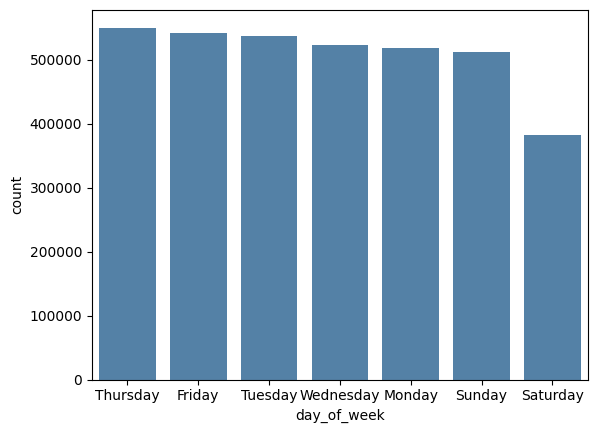

In [20]:
for i in ['departure','arrival']:
    data[i] = pd.to_datetime(data[i])

data['day_of_week'] = data['departure'].dt.day_name()
sns.barplot(x=data.day_of_week.value_counts().index,y=data.day_of_week.value_counts(), color='steelblue')

**Análisis de la Gráfica:**

1. Jueves:
Valor: 550,000
Observación: El día con el recuento más alto, lo que puede indicar un pico de actividad.
2. Viernes:
Valor: 540,000
Observación: Ligeramente menor que el jueves, sigue siendo un día con alta actividad.
3. Martes:
Valor: 530,000
Observación: Un poco menor que el viernes, pero sigue mostrando una alta actividad.
4. Miércoles:
Valor: 520,000
Observación: Un poco menor que el martes, pero aún considerablemente alto.
5. Lunes:
Valor: 510,000
Observación: Un poco menor que el miércoles, mostrando una ligera disminución.
6. Domingo:
Valor: 500,000
Observación: Un poco menor que el lunes, indicando una tendencia descendente hacia el fin de semana.
7. Sábado:
Valor: 350,000
Observación: Significativamente menor que los otros días, lo que puede indicar menor actividad o demanda.

**Interpretación:**
* La actividad o recuento es más alta hacia mediados de la semana, alcanzando su pico el jueves y disminuyendo gradualmente hasta el sábado.
* El sábado muestra una disminución significativa en comparación con los otros días, lo que puede deberse a varios factores como menos viajes, menor actividad laboral, etc.
* El patrón general sugiere que la mitad de la semana es la más activa, mientras que el fin de semana (especialmente el sábado) es menos activo.

# Precio medio por dia

<Axes: xlabel='day_of_week', ylabel='price'>

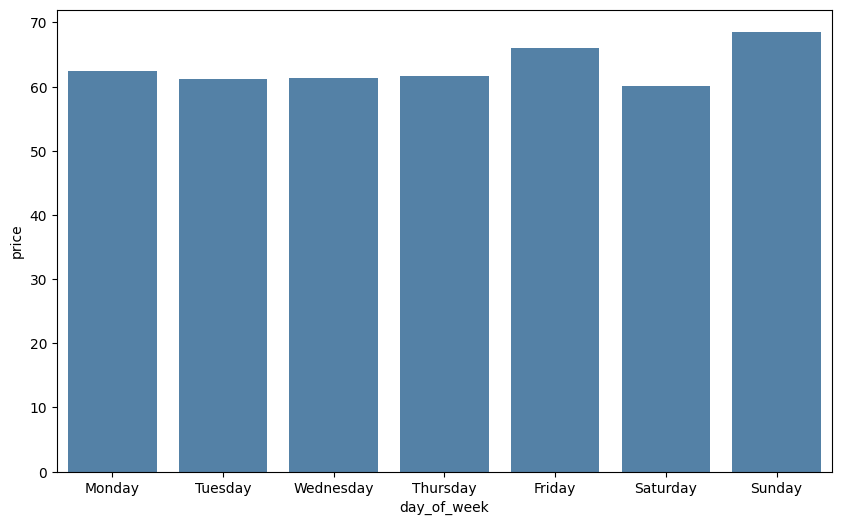

In [21]:
grouped_data = data.groupby('day_of_week')['price'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Convertir la serie a un DataFrame para seaborn
grouped_data = grouped_data.reset_index()

# Generar la gráfica de barras con seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='price', data=grouped_data, color='steelblue')

**Análisis de la Gráfica:**

1. Domingo:
Valor: 70,000
Observación: El día con la media más alta, lo que puede indicar un pico de actividad.
2. Viernes:
Valor: 68,000
Observación: Ligeramente menor que el domingo, sigue siendo un día con alta actividad.
3. Resto de dias:
Valor: 63,000
Observación: Significativamente menor que los otros días, lo que puede indicar menor actividad o demanda.

**Interpretación:**
* El sábado muestra una disminución significativa en comparación con los otros días, lo que puede deberse a varios factores como menos viajes, menor actividad laboral, etc.
* El patrón general sugiere que el domingo es el más activa, para la vuelta a la rutina laboral, por ejemplo.

# Cantidad de dinero desembolsado por dia 

<Axes: xlabel='day_of_week', ylabel='price'>

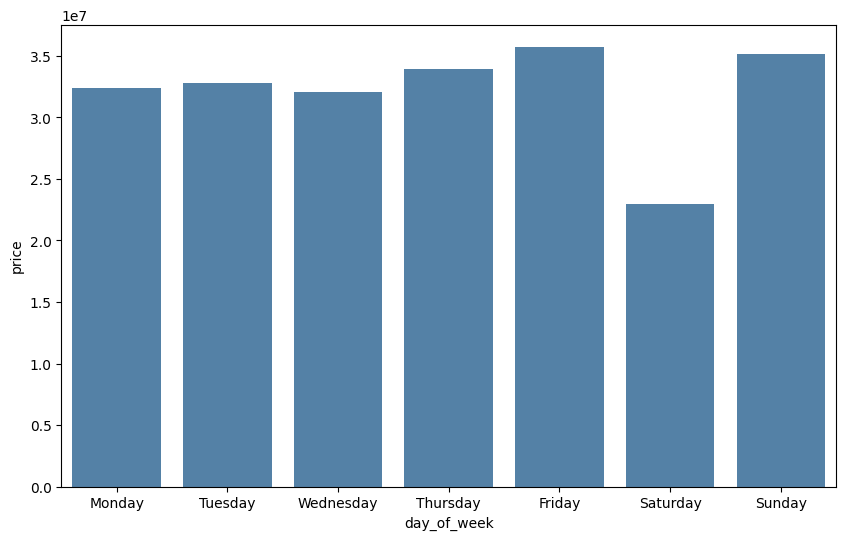

In [22]:
grouped_data = data.groupby('day_of_week')['price'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Convertir la serie a un DataFrame para seaborn
grouped_data = grouped_data.reset_index()

# Generar la gráfica de barras con seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='price', data=grouped_data, color='steelblue')

**Análisis de la Gráfica:**

1. Viernes y Domingo:
Valor: 35 millones
Observación: Los dias con el recuento más alto, lo que puede indicar un pico de actividad.
3. Sabado:
Valor: 25 millones
Observación: Casi la mitad que el viernes y domingo, posiblemente por la cantidad de viajes el viernes y domingo.
4. Resto de dias:
Valor: Media de 32 millones
Observación: Un poco menor que los otros días, regular en los cuatro dias.

**Interpretación:**
* La actividad o recuento es más alta los viernes y los domingos.
* El sábado muestra una disminución significativa en comparación con los otros días, lo que puede deberse a varios factores como menos viajes, menor actividad laboral, etc.
* El patrón general sugiere que los viernes y los domingos son los más activos, mientras que el sábado es menos activo. Esto puede deberse a que un viernes las personas quieran volverse a su lugar de origen o aprobechen a irse de fin de semana, de la misma forma el domingo, deseen volver a su residencia y a la rutina laboral.

# Viaje desde Madrid
Al ser el lugar de origen mas concurrido, vamos a hacer un estudio con los diferentes posibles trayectos con origen en Madrid.
## Viaje Madrid a Barcelona

In [23]:
df1 = data[(data['origin']=="MADRID") & (data['destination']=="BARCELONA")]
df1.head()

,origin,destination,departure,arrival,duration,vehicle_type,vehicle_class,price,fare,route,day_of_week
0,MADRID,BARCELONA,2019-04-18 05:50:00,2019-04-18 08:55:00,3.08,AVE,Preferente,68.95000,Promo,MADRID a BARCELONA,Thursday
1,MADRID,BARCELONA,2019-04-18 13:25:00,2019-04-18 16:24:00,2.98,AVE-TGV,Turista,107.70000,Flexible,MADRID a BARCELONA,Thursday
2,MADRID,BARCELONA,2019-04-18 06:30:00,2019-04-18 09:20:00,2.83,AVE,Turista,75.40000,Promo,MADRID a BARCELONA,Thursday
3,MADRID,BARCELONA,2019-04-18 15:30:00,2019-04-18 18:40:00,3.17,AVE,Preferente,63.14159,Promo,MADRID a BARCELONA,Thursday
4,MADRID,BARCELONA,2019-04-18 07:00:00,2019-04-18 09:30:00,2.50,AVE,Turista Plus,106.75000,Promo,MADRID a BARCELONA,Thursday


Duracion de cada tipo de trenes en los viajes Madrid a Barcelona

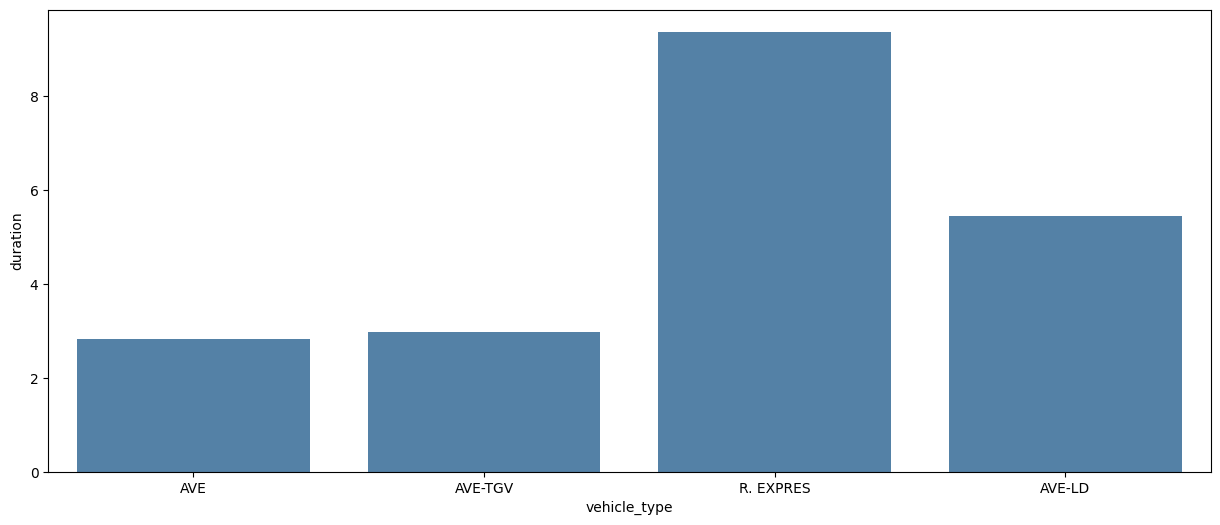

In [24]:
f,ax = plt.subplots(figsize=(15,6))
ax = sns.barplot(x="vehicle_type",y="duration",data=df1, color='steelblue')
plt.show()

**Analisis de la grafica**

En el recorrido Madrid - Barcelona, existen cuatro tipos de trenes:
1. R_EXPRES. Este es el tipo de transporte que mas tarda en llegar a su destino con un total de 9 horas. 
2. AVE-LD. Siguiente tipo de transporte con mayor duracion con un total de 6 horas.
3. AVE y AVE-TGV. Estos dos tipo de transporte tiene una duracion similar con un total de 3 horas.

Comparativa de los tipo de trenes frente al precio

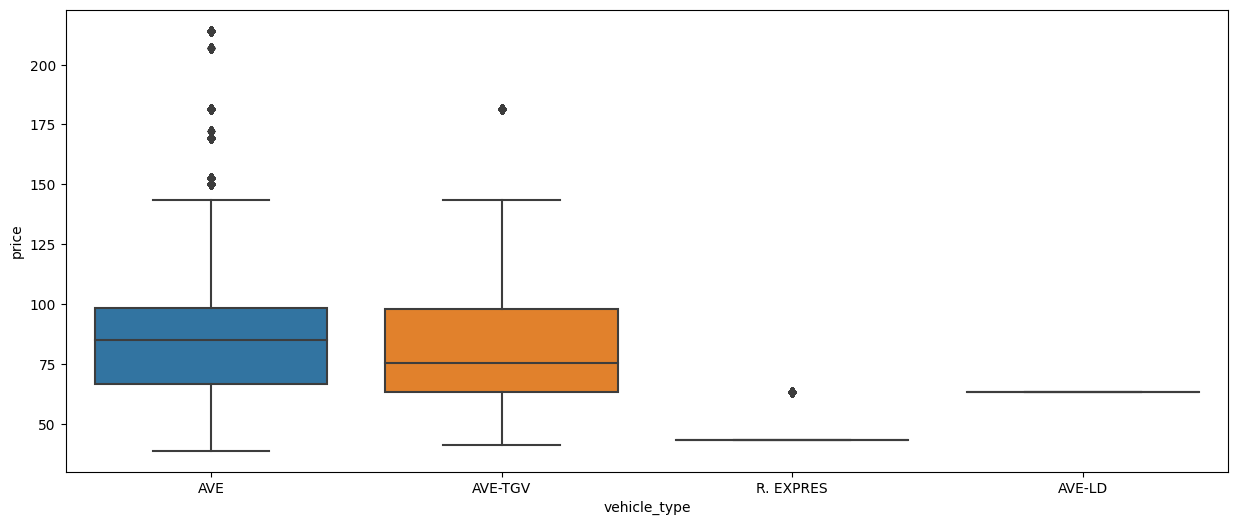

In [25]:
f,ax = plt.subplots(figsize=(15,6))
ax = sns.boxplot(x="vehicle_type",y="price",data=df1)
plt.show()

# Viajes Madrid a Sevilla

In [26]:
df1 = data[(data['origin']=="MADRID") & (data['destination']=="SEVILLA")]
df1.head()

,origin,destination,departure,arrival,duration,vehicle_type,vehicle_class,price,fare,route,day_of_week
272,MADRID,SEVILLA,2019-06-01 21:25:00,2019-06-02 00:10:00,2.75,AV City,Turista Plus,52.20,Promo,MADRID a SEVILLA,Saturday
273,MADRID,SEVILLA,2019-06-01 07:00:00,2019-06-01 09:55:00,2.92,AV City,Turista Plus,58.95,Promo,MADRID a SEVILLA,Saturday
274,MADRID,SEVILLA,2019-06-01 11:00:00,2019-06-01 13:32:00,2.53,AVE,Preferente,61.45,Promo,MADRID a SEVILLA,Saturday
275,MADRID,SEVILLA,2019-06-01 08:00:00,2019-06-01 10:32:00,2.53,AVE,Turista,47.30,Promo,MADRID a SEVILLA,Saturday
276,MADRID,SEVILLA,2019-06-01 09:45:00,2019-06-01 12:27:00,2.70,INTERCITY,Turista,62.20,Flexible,MADRID a SEVILLA,Saturday


Duracion de cada tipo de trenes en los viajes Madrid a Sevilla

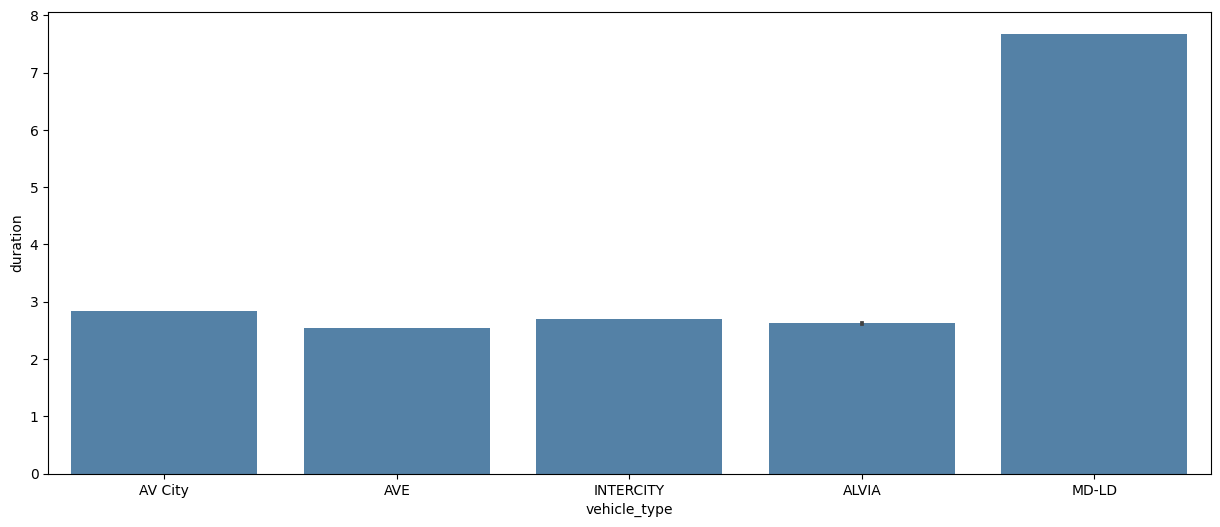

In [27]:
f,ax = plt.subplots(figsize=(15,6))
ax = sns.barplot(x="vehicle_type",y="duration",data=df1, color='steelblue')
plt.show()

**Analisis de la grafica**

En el recorrido Madrid - Sevilla, existen cinco tipos de trenes:
1. MD-LD. Este es el tipo de transporte que mas tarda en llegar a su destino con un total de 9 horas. 
2. Resto de trenes. Estos cuatro tipo de transporte tiene una duracion similar entre 2 horas 30 minutos y 3 horas.

Comparativa de los tipo de trenes frente al precioComparativa de los tipo de trenes frente al precio

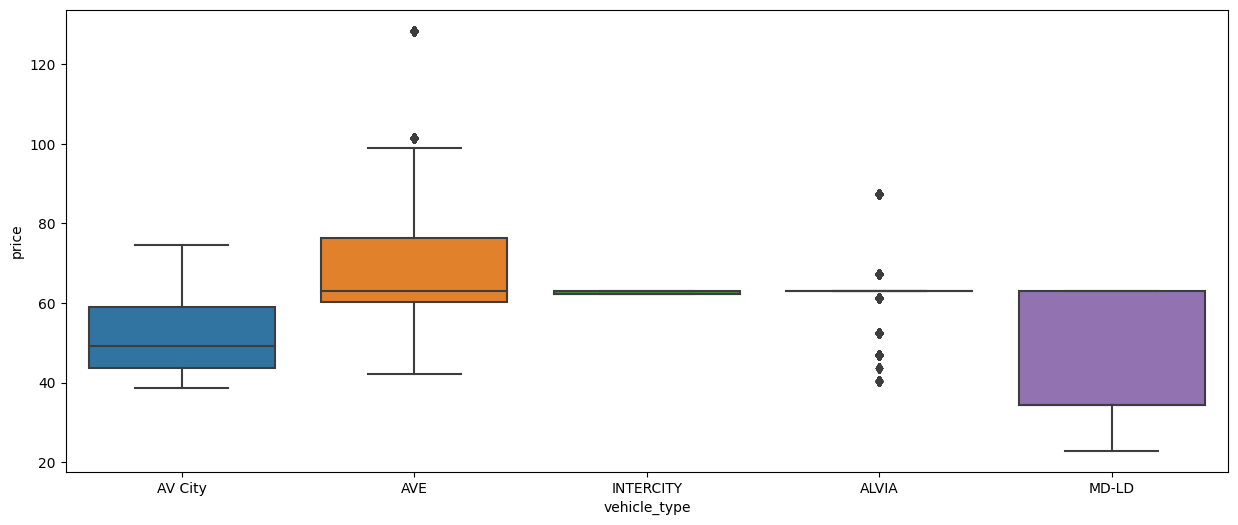

In [28]:
f,ax = plt.subplots(figsize=(15,6))
ax = sns.boxplot(x="vehicle_type",y="price",data=df1)
plt.show()

# Viajes Madrid a Valencia

In [29]:
df1 = data[(data['origin']=="MADRID") & (data['destination']=="VALENCIA")]
df1.head()

,origin,destination,departure,arrival,duration,vehicle_type,vehicle_class,price,fare,route,day_of_week
866,MADRID,VALENCIA,2019-05-11 14:10:00,2019-05-11 16:03:00,1.88,AVE,Turista,39.45,Promo,MADRID a VALENCIA,Saturday
867,MADRID,VALENCIA,2019-05-12 09:40:00,2019-05-12 11:24:00,1.73,AVE,Turista,27.80,Promo,MADRID a VALENCIA,Sunday
868,MADRID,VALENCIA,2019-05-11 10:40:00,2019-05-11 12:20:00,1.67,AVE,Turista,33.65,Promo,MADRID a VALENCIA,Saturday
869,MADRID,VALENCIA,2019-05-12 10:40:00,2019-05-12 12:20:00,1.67,AVE,Turista,33.65,Promo,MADRID a VALENCIA,Sunday
870,MADRID,VALENCIA,2019-05-11 08:40:00,2019-05-11 10:33:00,1.88,AVE,Turista,45.30,Promo,MADRID a VALENCIA,Saturday


Duracion de cada tipo de trenes en los viajes Madrid a Valencia

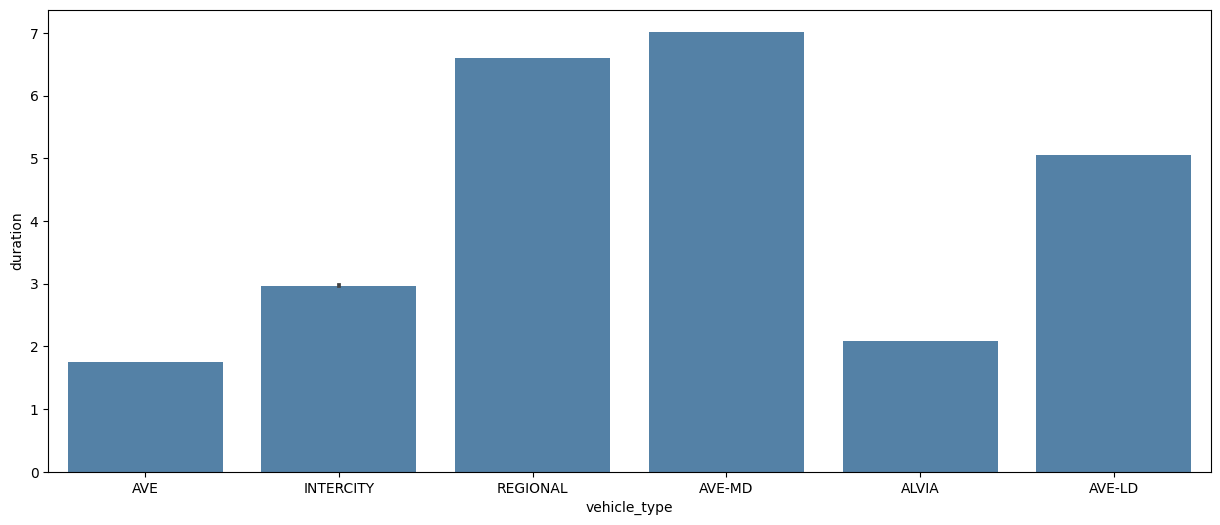

In [30]:
f,ax = plt.subplots(figsize=(15,6))
ax = sns.barplot(x="vehicle_type",y="duration",data=df1, color='steelblue')
plt.show()

**Analisis de la grafica**

En el recorrido Madrid - Valencia, existen seis tipos de trenes:
1. REGIONAL y AVE-MD. Estos tipos de transporte que mas tardan en llegar a su destino con un total de 7 horas. 
2. AVE-LD. Siguiente tipo de transporte con mayor duracion con un total de 5 horas.
3. INTERCITY. El siguiente en la lista con una duracion de 3 horas.
4. AVE y ALVIA. Estos dos tipos son los que menos duracion de trayecto con una media de entre 1 hora 45 minutos y 2 horas.

Comparativa de los tipo de trenes frente al precio

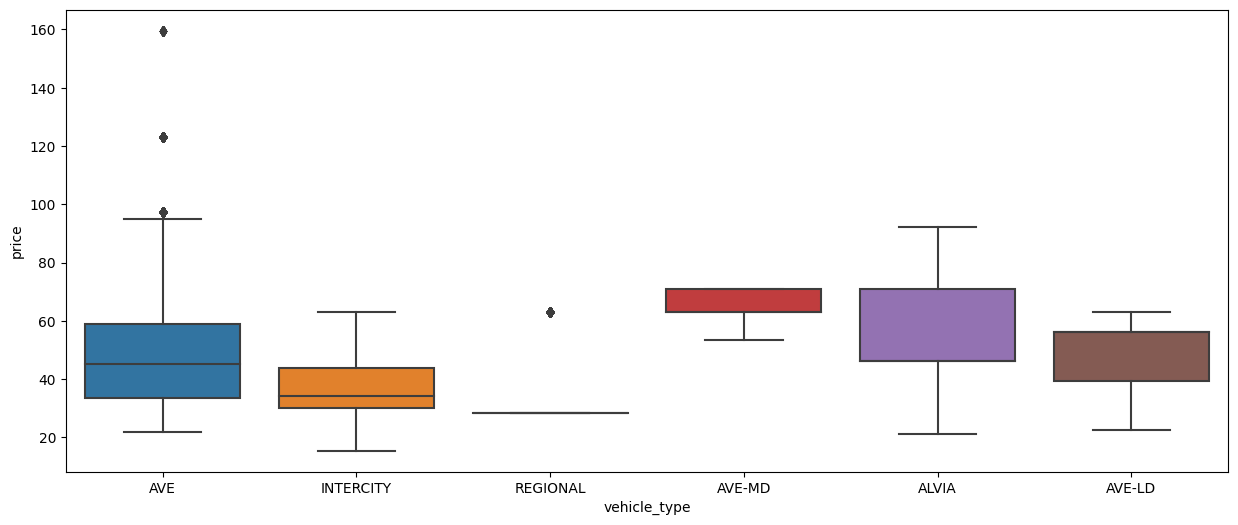

In [31]:
f,ax = plt.subplots(figsize=(15,6))
ax = sns.boxplot(x="vehicle_type",y="price",data=df1)
plt.show()

# Viajes Madrid a Ponferrada

In [32]:
df1 = data[(data['origin']=="MADRID") & (data['destination']=="PONFERRADA")]
df1.head()

,origin,destination,departure,arrival,duration,vehicle_type,vehicle_class,price,fare,route,day_of_week
549902,MADRID,PONFERRADA,2019-05-01 14:40:00,2019-05-01 18:33:00,3.88,AVE-MD,Turista con enlace,44.70,Promo +,MADRID a PONFERRADA,Wednesday
549964,MADRID,PONFERRADA,2019-05-01 14:40:00,2019-05-01 18:33:00,3.88,AVE-MD,Turista con enlace,44.70,Promo +,MADRID a PONFERRADA,Wednesday
549965,MADRID,PONFERRADA,2019-05-01 14:40:00,2019-05-01 18:52:00,4.20,AVE-LD,Turista con enlace,37.45,Promo,MADRID a PONFERRADA,Wednesday
549968,MADRID,PONFERRADA,2019-05-01 14:40:00,2019-05-01 18:52:00,4.20,AVE-LD,Turista con enlace,37.45,Promo,MADRID a PONFERRADA,Wednesday
549978,MADRID,PONFERRADA,2019-05-02 14:40:00,2019-05-02 18:33:00,3.88,AVE-MD,Turista con enlace,44.70,Promo +,MADRID a PONFERRADA,Thursday


Duracion de cada tipo de trenes en los viajes Madrid a Valencia

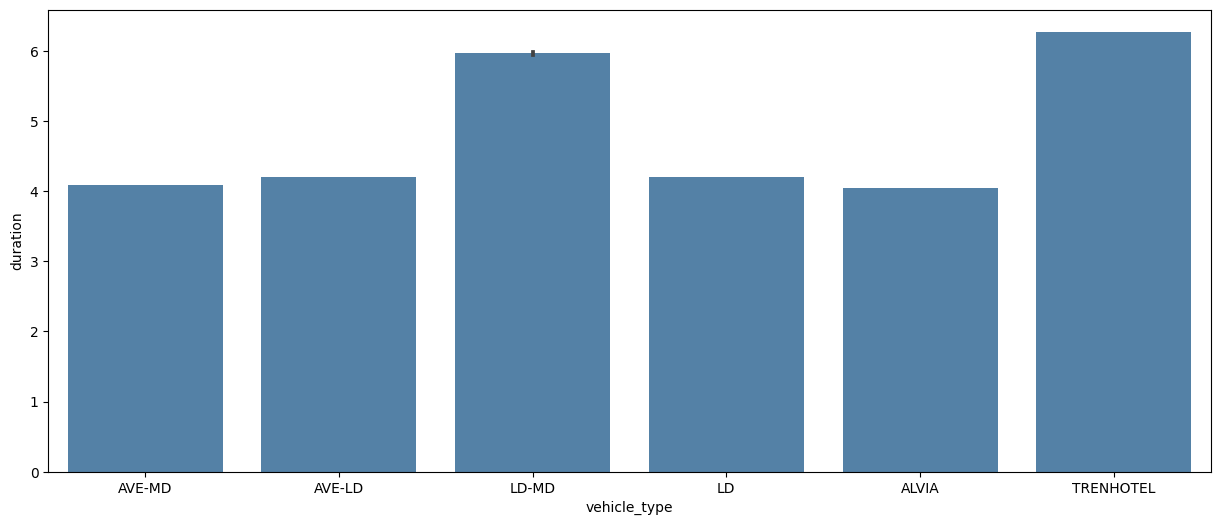

In [33]:
f,ax = plt.subplots(figsize=(15,6))
ax = sns.barplot(x="vehicle_type",y="duration",data=df1, color='steelblue')
plt.show()

**Analisis de la grafica**

En el recorrido Madrid - Ponferrada, existen seis tipos de trenes:
1. LD-MD y TRENHOTEL. Estos tipos de transporte que mas tardan en llegar a su destino con un total de 6 horas. 
2. RESTO. Estos tipos de transporte tiene una duracion similar con un total de 4 horas.

Comparativa de los tipo de trenes frente al precio

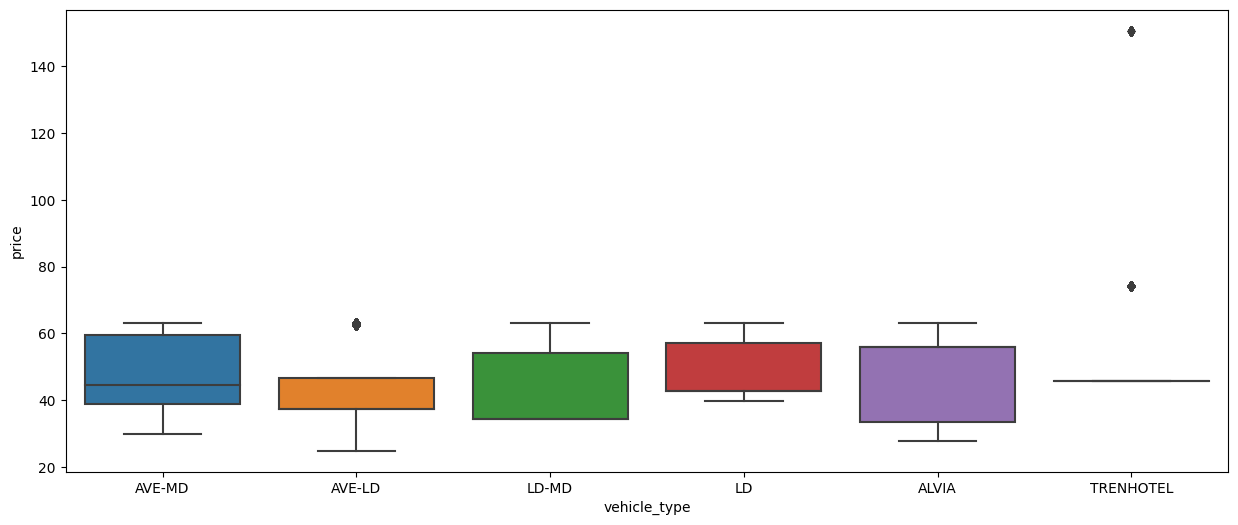

In [34]:
f,ax = plt.subplots(figsize=(15,6))
ax = sns.boxplot(x="vehicle_type",y="price",data=df1)
plt.show()

# Cantidad de rutas en el Dataset

In [35]:
cnt_ = data['route'].value_counts()

fig = {
  "data": [
    {
      "values": cnt_.values,
      "labels": cnt_.index,
      "domain": {"x": [0, .5]},
      "name": "Rutas",
      "hoverinfo":"label+percent+name",
      "hole": .5,
      "type": "pie"
    },],
  "layout": {
        "title":"Diagrama de rutas",
        "annotations": [
            { "font": { "size": 20},
              "showarrow": False,
             "text": "Grafico",
                "x": 0.50,
                "y": 1
            },
        ]
    }
}
iplot(fig)
cnt_

route
MADRID a BARCELONA     667892
MADRID a SEVILLA       592378
MADRID a VALENCIA      580298
SEVILLA a MADRID       561566
BARCELONA a MADRID     520502
VALENCIA a MADRID      431254
PONFERRADA a MADRID    123840
MADRID a PONFERRADA     88318
Name: count, dtype: int64

**Analisis de la grafica**

Podemos ver que el trayecto mas utilizado es el de Madrid - Barcelona, posiblemente por ser la comunicacion entre la capital de España con la segunda ciuad mas grande del pais. Seguidos de este trayecto se encuentrar el resto con un porcentaje similar, a excepcion de la counicacion Madrid - Ponferrada y Ponferrada - Madrid, al ser Ponferrada la ciudad mas pequeña del estudio.

# Cantidad de tipo de trenes en el Dataset

In [36]:
cnt_ = data['vehicle_type'].value_counts()

fig = {
  "data": [
    {
      "values": cnt_.values,
      "labels": cnt_.index,
      "domain": {"x": [0, .5]},
      "name": "Tipos de trenes",
      "hoverinfo":"label+percent+name",
      "hole": .7,
      "type": "pie"
    },],
  "layout": {
        "title":"Diagrama de tipos de trenes",
        "annotations": [
            { "font": { "size": 20},
              "showarrow": False,
             "text": "Grafica",
                "x": 0.50,
                "y": 1
            },
        ]
    }
}
iplot(fig)
cnt_

vehicle_type
AVE          2489129
ALVIA         261530
REGIONAL      185934
INTERCITY     143479
AV City       101556
MD-LD          69070
LD             54868
AVE-MD         49142
AVE-TGV        47258
R. EXPRES      43654
AVE-LD         40774
LD-MD          38076
TRENHOTEL      23308
MD-AVE          9600
MD              8224
LD-AVE           446
Name: count, dtype: int64

**Analisis de la grafica**

El AVE es el tipo de transporte mas utilizado en este estudio. Posiblemente por ser el tren con menor duracion de recorrido. Seguido de este, tenemos el resto de transportes con similar porcentaje.


# **Conclusion**

1. **Ciudad de origen más concurrida:**
La ciudad de origen más concurrida es Madrid. Esto se debe probablemente a su condición de capital de España, lo que la convierte en un importante centro de negocios, turismo y actividades culturales. Además, Madrid cuenta con una gran infraestructura de transporte, lo que facilita la movilidad de personas desde y hacia la ciudad.
2. **Ciudad de destino más concurrida:**
Similar a la ciudad de origen, la ciudad de destino más concurrida también es Madrid. La capital española atrae a numerosos visitantes por motivos de trabajo, turismo y eventos, consolidándose como un punto central en la red de transporte del país.
3. **Tipo de transporte más utilizado:**
El tipo de transporte más utilizado es el AVE. Esta popularidad puede atribuirse a que el AVE ofrece tiempos de viaje significativamente más cortos en comparación con otros medios de transporte terrestre. Su velocidad y frecuencia de salidas lo hacen una opción preferida para quienes necesitan realizar desplazamientos rápidos y eficientes.
4. **Clase de billete más comprada:**
La clase de billete más comprada es la clase Turista. Esta preferencia se debe probablemente a que la clase Turista es la tarifa más económica, lo que la hace accesible para un mayor número de personas, especialmente para aquellos que buscan una opción de viaje asequible sin renunciar a la comodidad.
5. **Días con más viajes:**
Los días con más viajes son el viernes y el domingo. El viernes registra un alto número de viajes, posiblemente debido a que muchas personas comienzan sus fines de semana, aprovechando para desplazarse a otras ciudades o destinos de ocio. El domingo, por otro lado, es concurrido debido a que muchas personas regresan a sus ciudades de origen para prepararse para la semana laboral que comienza el lunes.
6. **Precios de los viajes:**
Los precios de los viajes son más altos los viernes y domingos. Esta tendencia de precios más elevados se explica por la mayor demanda de viajes en estos días, como se mencionó anteriormente. El incremento en la demanda provoca un aumento en los precios, reflejando la dinámica de oferta y demanda en el mercado de transporte.